In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
spotify_df = pd.read_csv('data.csv')

In [5]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [6]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,['show tunes'],"""Cats"" 1981 Original London Cast",0.590111,0.467222,250318.555556,0.394003,0.011400,0.290833,-14.448000,0.210389,117.518111,0.389500,38.333333,5,1,9
1,[],"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,30.576923,5,1,26
2,[],"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.857143,0,1,7
3,[],"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.851852,0,1,27
4,[],"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,43.000000,5,1,7


In [7]:
data_w_genre.dtypes

genres               object
artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
dtype: object

In [8]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [9]:
data_w_genre['genres'].values[0][0]

'['

In [10]:
#extract genre ad input into a list
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [11]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

In [12]:
#extract artists from the string list
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [13]:
spotify_df['artists'].values[0]

"['Sergei Rachmaninoff', 'James Levine', 'Berliner Philharmoniker']"

In [14]:
spotify_df['artists_upd_v1'].values[0][0]

'Sergei Rachmaninoff'

In [15]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1
143,0.300,1921,0.772,"[""Scarlet D'Carpio""]",0.560,249370,0.313,0,7b4eHImKQ51DYaQvNTdtEp,0.000005,6,0.115,-8.346,0,Himno Nacional del Perú,0,1921-09-23,0.0376,107.501,[]
234,0.902,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.708,194533,0.361,0,1xEEYhWxT4WhDQdxfPCT8D,0.883000,0,0.103,-11.764,0,Snake Rag,20,1923,0.0441,105.695,[]
238,0.554,1923,0.996,"[""King Oliver's Creole Jazz Band""]",0.546,170827,0.189,0,3rauXVLOOM5BlxWqUcDpkg,0.908000,0,0.339,-15.984,1,Chimes Blues,13,1923,0.0581,80.318,[]
244,0.319,1923,0.995,"[""Clarence Williams' Blue Five""]",0.520,197493,0.153,0,1UdqHVRFYMZKU2Q7xkLtYc,0.131000,0,0.353,-14.042,1,Pickin' On Your Baby,11,1923,0.0440,102.937,[]
249,0.753,1923,0.994,"[""King Oliver's Creole Jazz Band""]",0.359,187227,0.357,0,5SvyP1ZeJX1jA7AOZD08NA,0.819000,3,0.290,-11.810,1,Tears,10,1923,0.0511,205.053,[]


In [16]:
#regex to handle artists with apostrophe in their title
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [17]:
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [18]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [19]:
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,...,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You
38319,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,1M4qEo4HE3PRaCOM7EXNJq,0.000007,...,1,Adore You,77,2019-12-06,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [20]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [21]:
spotify_df[spotify_df['name']=='Adore You']

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song
19425,0.569,2019,0.0237,['Harry Styles'],0.676,207133,0.771,0,3jjujdWJ72nww5eGnfs2E7,0.000007,...,1,Adore You,88,2019-12-13,0.0483,99.048,[Harry Styles],[],[Harry Styles],Harry StylesAdore You


In [22]:
#now we can explode this column and merge
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [23]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [24]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='02GDntOXexBFUvSgaXLPkd']

,artists_upd,id,genres,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres_upd
45050,Sergei Rachmaninoff,02GDntOXexBFUvSgaXLPkd,"['classical', 'post-romantic era', 'russian ro...",Sergei Rachmaninoff,0.982384,0.340674,261014.58209,0.144225,0.793356,0.236443,-20.485082,0.041968,95.200198,0.264284,4.33209,2.0,1.0,268.0,"[classical, post-romantic_era, russian_romanti..."


In [25]:
#group by song id and create lists, consoldiate these lists and output the unique values
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [26]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [27]:
artists_genres_consolidated.head()

,id,genres_upd,consolidates_genre_lists
0,000G1xMMuwxNHmwVsBdtj1,"[[candy_pop, dance_rock, new_wave, new_wave_po...","[new_wave_pop, candy_pop, dance_rock, power_po..."
1,000GyYHG4uWmlXieKLij8u,"[[alternative_hip_hop, conscious_hip_hop, minn...","[conscious_hip_hop, minnesota_hip_hop, alterna..."
2,000Npgk5e2SgwGaIsN3ztv,"[[classic_bollywood, classic_pakistani_pop, fi...","[sufi, classic_bollywood, classic_pakistani_po..."
3,000ZxLGm7jDlWCHtcXSeBe,"[[boogie-woogie, piano_blues, ragtime, stride]]","[piano_blues, stride, boogie-woogie, ragtime]"
4,000jBcNljWTnyjB4YO7ojf,[[]],[]


In [28]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

In [29]:
spotify_df.tail()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists
156602,0.768,1997,0.2820,"[""Lil' Kim"", ""Lil' Cease""]",0.748,275947,0.693,0,2LP2uDQQ7eLMcUVE4aOpAV,0.00000,...,Crush on You (feat. Lil' Cease) - Remix,56,1997-06-30,0.2780,88.802,"[ Kim"", ""Lil]","[Lil' Kim, Lil' Cease]","[ Kim"", ""Lil]","Kim"", ""LilCrush on You (feat. Lil' Cease) - R...",NaN
156603,0.792,2004,0.0248,"[""Lil' Flip"", 'Lea']",0.814,225173,0.387,1,4s0o8TJHfX9LLHa0umnOzT,0.00000,...,Sunshine (feat. Lea),62,2004-03-30,0.0945,93.961,"[ Flip"", ]",[Lil' Flip],"[ Flip"", ]","Flip"", Sunshine (feat. Lea)",NaN
156604,0.697,1999,0.0516,"[""Ol' Dirty Bastard"", 'Kelis', 'Rich Travali']",0.934,239547,0.459,1,6YYd5MLpu45J0uLrMdivF7,0.00000,...,Got Your Money (feat. Kelis),66,1999,0.1890,103.040,"[ Dirty Bastard"", , , ]",[Ol' Dirty Bastard],"[ Dirty Bastard"", , , ]","Dirty Bastard"", Got Your Money (feat. Kelis)",NaN
156605,0.429,1994,0.0249,"[""World Class Wreckin' Cru"", ""Michel 'Le""]",0.715,351040,0.490,0,3hoiinUc5VA9xUEJID7R8V,0.00017,...,Turn Off The Lights - Rap,36,1994-04-06,0.0479,129.309,"[ Cru"", ""Michel ]","[World Class Wreckin' Cru, Michel 'Le]","[ Cru"", ""Michel ]","Cru"", ""Michel Turn Off The Lights - Rap",NaN
156606,0.273,1996,0.0113,"[""Rappin' 4-Tay"", 'MC Breed', 'Too $hort']",0.897,337973,0.414,1,78859Af0fmA9VTlgnOHTAP,0.00011,...,Never Talk Down,35,1996,0.2460,96.039,"[ 4-Tay"", , , ]",[Rappin' 4-Tay],"[ 4-Tay"", , , ]","4-Tay"", Never Talk Down",NaN


In [30]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [31]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [32]:
ohe_cols = 'popularity'

In [33]:
spotify_df['popularity'].describe()

count    156607.000000
mean         31.307215
std          21.712234
min           0.000000
25%          11.000000
50%          33.000000
75%          48.000000
max         100.000000
Name: popularity, dtype: float64

In [34]:
#create 5 point buckets for popularity
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [35]:
#fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [36]:
spotify_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red
0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,...,31,1989-06-15,0.0272,71.979,[조정현],[],[조정현],조정현그아픔까지사랑한거야,[classic_korean_pop],6
1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,...,35,1992-12-22,0.0395,200.341,[黑豹],[],[黑豹],黑豹DON'T BREAK MY HEART,"[chinese_indie_rock, chinese_indie]",7
2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,...,23,1963-05-28,0.0443,85.936,[黃國隆],[],[黃國隆],黃國隆藝旦調,[],4
3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,...,23,1963-05-28,0.0697,124.273,"[黃國隆, 王秋玉]",[],"[黃國隆, 王秋玉]",黃國隆草螟弄雞公,[],4
4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,...,23,1963-05-28,0.0419,124.662,[黃國隆],[],[黃國隆],黃國隆思想起,[],4


In [37]:
#simple function to create OHE features, this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [38]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [39]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [40]:
complete_feature_set.head()

,genre|21st_century_classical,genre|432hz,genre|_hip_hop,genre|a_cappella,genre|abstract,genre|abstract_beats,genre|abstract_hip_hop,genre|accordeon,genre|accordion,genre|acid_house,...,year|2012,year|2013,year|2014,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ghebdwe2pNXT4eL34T7pW
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3KIuCzckjdeeVuswPo20mC
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4prhqrLXYMjHJ6vpRAlasx
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5xFXTvnEe03SyvFpo6pEaE
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6Pqs2suXEqCGx7Lxg5dlrB


In [41]:
# connect to spotify API
client_id = '623686c58ede499385d69cbbb955b44e'
client_secret= '24dcc0e70a1e45a98ed30ccc9356f0c0'

In [42]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [43]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [44]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8888/callback')

In [45]:
sp = spotipy.Spotify(auth=token)

In [46]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [47]:
id_name

{'lighter': '58IxZ9UEbNIDuZrq42nch3',
 'positions': '0lUX5B8hrsGPhLQfUqz2q4',
 'NEXT': '0vIv34QO7UzbNrMLOlBD4N',
 'fawl+wintur': '2I3z0Ug31gUyMPb6X7Mpdq',
 'again and again': '7qp8VXfvqt8qaSng2pCQkd',
 'slower': '5QEYW7foeznkDbxxLlLcvQ',
 ':*********': '4k6IiHDdFgiEhSLDXQZisd',
 'ria turnz 21': '4yBVDF7jZ3APuqyFJohTm8',
 'zzzzz': '0c07H0YuwEJJjZmB29D2Bd',
 'sea': '3Cb7kLKYU1TfsqPlCVZy7w',
 'talk 2 me nice': '3FoxC7ytJHhUJHQ3GoWGgC',
 'dreams': '6tNmZWKqlKOoxJdxNdWVdt',
 'sweet summer ': '1nAV5tP16yi9P5eRyzp3ki',
 'spring!!': '6mKtk8s1fQMikNFYuq1ThT',
 'ariana 2.0': '5A33AO0hZeurm0ykUmwbqN',
 'femmemaster3000': '7GBQwLnP6tcpE1SoKwLADD',
 ' beatz': '70ywjIsZKFYQoV7gt9VLIr',
 'punjabi princess': '6JDI5EhTe8fwJptJ32rfsL',
 'when it rains it pours': '2MHPCEwtWnXHmI9M0LrEpq',
 'soft': '3MXQuDhWsSs5dj2OTzB3cF',
 'cold': '73fb7hu9hH3wUvnbEqWM9L',
 'folk': '5ipWadWhzLxzo9LGGy21LI',
 ':3': '7Ir8EAwVWHhmTDAPCQhN67',
 'dude': '1tR42Y5CwD82xMoLCfR4qh',
 'indian': '1IHvdPdG8EtF2uxJnEGMJ3',
 'sick': 

In [48]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [49]:
id_name

{'lighter': '58IxZ9UEbNIDuZrq42nch3',
 'positions': '0lUX5B8hrsGPhLQfUqz2q4',
 'NEXT': '0vIv34QO7UzbNrMLOlBD4N',
 'fawl+wintur': '2I3z0Ug31gUyMPb6X7Mpdq',
 'again and again': '7qp8VXfvqt8qaSng2pCQkd',
 'slower': '5QEYW7foeznkDbxxLlLcvQ',
 ':*********': '4k6IiHDdFgiEhSLDXQZisd',
 'ria turnz 21': '4yBVDF7jZ3APuqyFJohTm8',
 'zzzzz': '0c07H0YuwEJJjZmB29D2Bd',
 'sea': '3Cb7kLKYU1TfsqPlCVZy7w',
 'talk 2 me nice': '3FoxC7ytJHhUJHQ3GoWGgC',
 'dreams': '6tNmZWKqlKOoxJdxNdWVdt',
 'sweet summer ': '1nAV5tP16yi9P5eRyzp3ki',
 'spring!!': '6mKtk8s1fQMikNFYuq1ThT',
 'ariana 2.0': '5A33AO0hZeurm0ykUmwbqN',
 'femmemaster3000': '7GBQwLnP6tcpE1SoKwLADD',
 ' beatz': '70ywjIsZKFYQoV7gt9VLIr',
 'punjabi princess': '6JDI5EhTe8fwJptJ32rfsL',
 'when it rains it pours': '2MHPCEwtWnXHmI9M0LrEpq',
 'soft': '3MXQuDhWsSs5dj2OTzB3cF',
 'cold': '73fb7hu9hH3wUvnbEqWM9L',
 'folk': '5ipWadWhzLxzo9LGGy21LI',
 ':3': '7Ir8EAwVWHhmTDAPCQhN67',
 'dude': '1tR42Y5CwD82xMoLCfR4qh',
 'indian': '1IHvdPdG8EtF2uxJnEGMJ3',
 'sick': 

In [82]:
playlist_nostalgia = create_necessary_outputs('nostalgia', id_name,spotify_df)
#playlist_again = create_necessary_outputs('again and again',id_name, spotify_df)
#playlist_summer = create_necessary_outputs('sweet summer ',id_name, spotify_df)

In [90]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    temp = df['url'].values
    plt.figure(figsize=(15, int(0.625 * len(temp) / 5 + 1)))  # Adjusting figure size
    columns = 5  # Number of columns in the grid

    for i, url in enumerate(temp):
        # Fixing the number of rows with integer division
        plt.subplot((len(temp) + columns - 1) // columns, columns, i + 1)

        image = io.imread(url)  # Read image from URL
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.axis('off')  # Hides axis for cleaner look
        plt.xlabel(df['name'].values[i], fontsize=12)

    # Improve layout
    plt.tight_layout(h_pad=0.2, w_pad=0)
    plt.subplots_adjust(wspace= None, hspace=None)
    plt.show()


In [88]:
playlist_nostalgia

,artist,name,id,url,date_added
99,T.I.,Live Your Life,3jlbL2OTD5YmIunYzgQTAN,https://i.scdn.co/image/ab67616d00001e02b6d447...,2021-09-26 01:32:17+00:00
98,Justin Bieber,Somebody To Love,3rLIv187BhjyweFe89SgLn,https://i.scdn.co/image/ab67616d00001e02629dc9...,2021-09-26 01:32:12+00:00
95,USHER,Scream,12eMQUn2GzfsfsQLH53M19,https://i.scdn.co/image/ab67616d00001e0267904c...,2021-09-26 01:31:56+00:00
94,Pitbull,Give Me Everything (feat. Nayer),4QNpBfC0zvjKqPJcyqBy9W,https://i.scdn.co/image/ab67616d00001e021dc748...,2021-09-26 01:31:40+00:00
92,Flo Rida,Wild Ones (feat. Sia),1NpW5kyvO4XrNJ3rnfcNy3,https://i.scdn.co/image/ab67616d00001e02871d85...,2021-09-26 01:31:27+00:00
...,...,...,...,...,...
7,Rihanna,Umbrella,49FYlytm3dAAraYgpoJZux,https://i.scdn.co/image/ab67616d00001e02f9f271...,2019-11-10 03:59:53+00:00
6,Soulja Boy,Crank That (Soulja Boy),66TRwr5uJwPt15mfFkzhbi,https://i.scdn.co/image/ab67616d00001e028a6a32...,2019-11-10 03:59:42+00:00
2,Miley Cyrus,Party In The U.S.A.,5Q0Nhxo0l2bP3pNjpGJwV1,https://i.scdn.co/image/ab67616d00001e02d6c3ad...,2019-11-10 03:58:51+00:00
1,OneRepublic,All The Right Moves,5XRHGXut00SrJUFmcn2lQF,https://i.scdn.co/image/ab67616d00001e0277a7bd...,2019-11-10 03:58:39+00:00


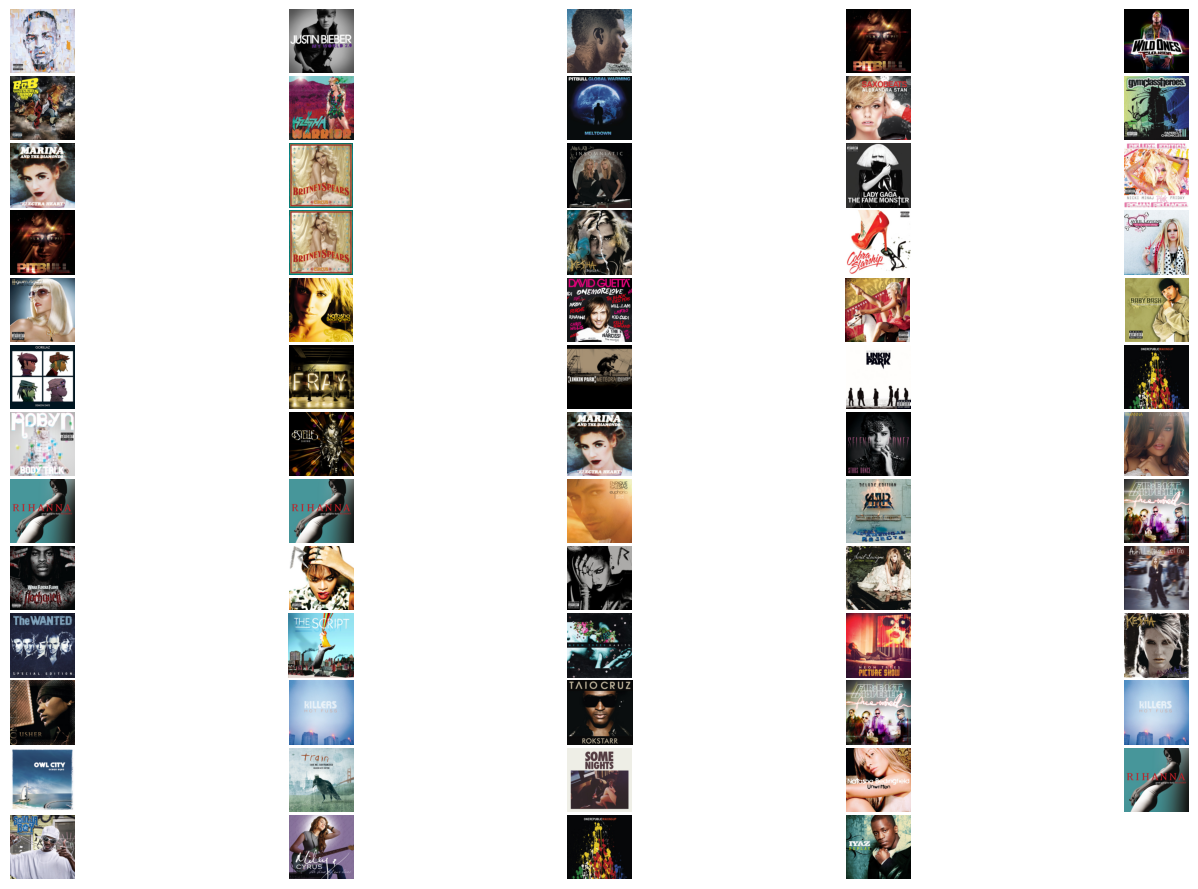

In [91]:
visualize_songs(playlist_nostalgia)

In [92]:
#create a playlist vector
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [94]:
complete_feature_set_playlist_vector_nostalgia, complete_feature_set_nonplaylist_nostalgia = generate_playlist_feature(complete_feature_set, playlist_nostalgia, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [95]:
complete_feature_set_playlist_vector_nostalgia.shape

(3070,)

In [96]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40

In [98]:
nostalgia_top40 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_nostalgia, complete_feature_set_nonplaylist_nostalgia)

In [99]:
nostalgia_top40

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,popularity_red,sim,url
3545,0.950,2008,0.428000,['will.i.am'],0.842,221467,0.791,0,4bAFo6r2ODMDoqM5YHV2gM,0.000000,...,0.0437,126.962,[will.i.am],[],[will.i.am],will.i.amI Like To Move It,"[pop, pop_dance, post-teen_pop, pop_rap, dance...",13,0.848812,https://i.scdn.co/image/ab67616d00001e024fa16c...
3550,0.863,2008,0.141000,['will.i.am'],0.965,201640,0.783,0,5wA5mA9v9lPxAaSg1FagG6,0.000231,...,0.0980,119.940,[will.i.am],[],[will.i.am],will.i.amBig And Chunky,"[pop, pop_dance, post-teen_pop, pop_rap, dance...",12,0.846101,https://i.scdn.co/image/ab67616d00001e024fa16c...
80974,0.864,2012,0.000802,['Katy Perry'],0.687,227333,0.792,0,3oL3XRtkP1WVbMxf7dtTdu,0.000000,...,0.0353,133.962,[Katy Perry],[],[Katy Perry],Katy PerryThe One That Got Away,"[dance_pop, pop, pop_dance, post-teen_pop]",15,0.841523,https://i.scdn.co/image/ab67616d00001e02937af3...
80987,0.696,2008,0.002230,['Katy Perry'],0.699,179640,0.760,0,005lwxGU1tms6HGELIcUv9,0.000000,...,0.0677,129.996,[Katy Perry],[],[Katy Perry],Katy PerryI Kissed A Girl,"[dance_pop, pop, pop_dance, post-teen_pop]",13,0.837811,https://i.scdn.co/image/ab67616d00001e02cd3978...
80982,0.769,2012,0.000417,['Katy Perry'],0.678,216160,0.918,0,1nZzRJbFvCEct3uzu04ZoL,0.000000,...,0.0355,130.028,[Katy Perry],[],[Katy Perry],Katy PerryPart Of Me,"[dance_pop, pop, pop_dance, post-teen_pop]",14,0.837689,https://i.scdn.co/image/ab67616d00001e02937af3...
138438,0.235,2008,0.073000,['Britney Spears'],0.724,224400,0.695,0,4fixebDZAVToLbUCuEloa2,0.000000,...,0.0622,139.000,[Britney Spears],[],[Britney Spears],Britney SpearsWomanizer,"[pop, pop_dance, post-teen_pop, pop_rap, dance...",15,0.837384,https://i.scdn.co/image/ab67616d00001e0254c6ed...
3543,0.849,2008,0.498000,['will.i.am'],0.694,205360,0.678,0,0fvQvActgYOEihSxVPrqNP,0.000000,...,0.1340,141.977,[will.i.am],[],[will.i.am],will.i.amThe Traveling Song,"[pop, pop_dance, post-teen_pop, pop_rap, dance...",9,0.836829,https://i.scdn.co/image/ab67616d00001e024fa16c...
80981,0.942,2012,0.056300,['Katy Perry'],0.825,231920,0.759,1,0rXw5rWZpOdfeeCbMln8MU,0.000000,...,0.0427,139.975,[Katy Perry],[],[Katy Perry],Katy PerryPeacock,"[dance_pop, pop, pop_dance, post-teen_pop]",11,0.836308,https://i.scdn.co/image/ab67616d00001e02937af3...
132354,0.575,2012,0.000739,['Christina Aguilera'],0.593,239853,0.781,0,2pmtavvgqZN52EePYxutgk,0.000000,...,0.0547,103.024,[Christina Aguilera],[],[Christina Aguilera],Christina AguileraYour Body,"[pop, pop_dance, post-teen_pop, pop_rap, dance...",12,0.835846,https://i.scdn.co/image/ab67616d00001e021736bd...
80985,0.855,2008,0.010900,['Katy Perry'],0.617,198347,0.887,0,3FTyr2M2y5D2jjOStBGutn,0.000000,...,0.0943,149.970,[Katy Perry],[],[Katy Perry],Katy PerryIf You Can Afford Me,"[dance_pop, pop, pop_dance, post-teen_pop]",8,0.835788,https://i.scdn.co/image/ab67616d00001e02cd3978...


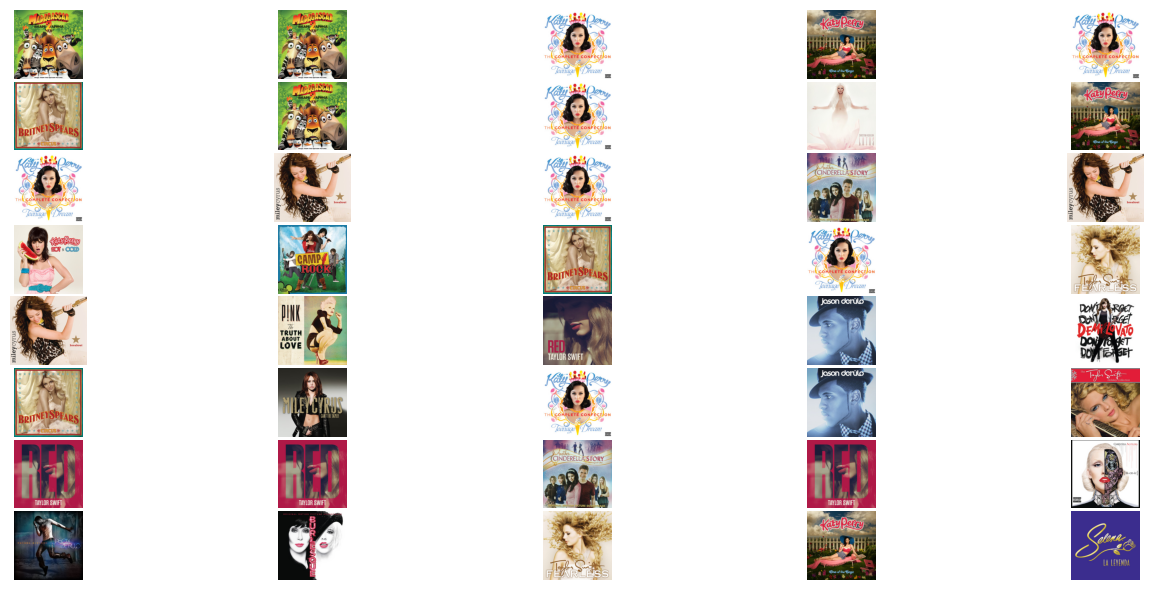

In [100]:
visualize_songs(nostalgia_top40)